# Calculate Nino 3.4 index to check if eruptions line up with El Nino events
This script opens up all the CMIP6 historical model run files with data on precipitation pr and surface temperature tas and loops over the files. It calculates the Nino3.4 index for the data to test which years have an El Nino event and if they occur after volcanic eruptions. 


In [1]:
import xarray as xr, matplotlib.pyplot as plt
#import sys 
#sys.path.append('') # use this if the function file is in a different directory to the notebook
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load

In [2]:
# import custom functions
import anomaly_function as func # imports the function
import model_figures as func2

In [3]:
# use this to reload the function file if I make any edits to it
func = reload(func) 
func2 = reload(func2)

In [4]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon/ts/gr1.5

v20200302


In [5]:
!ls /g/data/lp01/CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Amon

huss  pr  psl  tas  ts	uas  vas  wap


In [6]:
# store each section of the directory as a string
institution_dir = '/g/data/lp01/CMIP6/CMIP/'
tas_dir = '/historical/r1i1p1f1/Amon/tas/gr1.5/'
pr_dir = '/historical/r1i1p1f1/Amon/pr/gr1.5/'
ts_dir = '/historical/r1i1p1f1/Amon/ts/gr1.5/'
print(institution_dir, tas_dir, pr_dir, ts_dir)

/g/data/lp01/CMIP6/CMIP/ /historical/r1i1p1f1/Amon/tas/gr1.5/ /historical/r1i1p1f1/Amon/pr/gr1.5/ /historical/r1i1p1f1/Amon/ts/gr1.5/


## Read in model data

In [7]:
models_tas = func.read_models(institution_dir, tas_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model MPI-ESM1-2-HR has different time so is now removed
Model E3SM-1-0 has different time so is now removed
Model EC-Earth3-Veg has different time so is now removed
45 models have been successfully loaded into an xarray


In [8]:
models_pr = func.read_models(institution_dir, pr_dir, '1850-01','2015-01')

48 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
47 models have been successfully loaded into an xarray


In [9]:
models_ts = func.read_models(institution_dir, ts_dir, '1850-01','2015-01')

49 model paths found and loaded into the dictionary "models"
Path for MCM-UA-1-0 does not exist
Model E3SM-1-0 has different time so is now removed
47 models have been successfully loaded into an xarray


In [10]:
# make sure the models are the same for both vairables
# delete the height from the models_tas array (if it hasn't been deleted already)
if 'height' in models_tas:
    del models_tas['height']
# delete models that aren't common between variables
models_tas = models_tas.where(models_tas.model.isin(models_pr.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_tas.model), drop = True)
models_pr = models_pr.where(models_pr.model.isin(models_ts.model), drop = True)
models_ts = models_ts.where(models_ts.model.isin(models_tas.model), drop = True)

#chekc that the models are the same for both variables and if so print True
models_tas.model.equals(models_ts.model)

True

In [11]:
# get rid of models with issues
models = models_ts.drop_sel(model=['CIESM'])

In [12]:
# sort models alphabetically and prints final model list
models = models.sortby('model')
print('The following', len(models.model.data), 'models will be used in all subsequent calculations: \n')
print(models.model.data)

The following 43 models will be used in all subsequent calculations: 

['ACCESS-CM2' 'ACCESS-ESM1-5' 'AWI-CM-1-1-MR' 'AWI-ESM-1-1-LR'
 'BCC-CSM2-MR' 'BCC-ESM1' 'CAMS-CSM1-0' 'CAS-ESM2-0' 'CESM2' 'CESM2-FV2'
 'CESM2-WACCM' 'CESM2-WACCM-FV2' 'CMCC-CM2-HR4' 'CMCC-CM2-SR5' 'CanESM5'
 'E3SM-1-1' 'E3SM-1-1-ECA' 'EC-Earth3' 'EC-Earth3-AerChem'
 'EC-Earth3-Veg-LR' 'FGOALS-f3-L' 'FGOALS-g3' 'FIO-ESM-2-0' 'GFDL-CM4'
 'GFDL-ESM4' 'GISS-E2-1-G' 'GISS-E2-1-G-CC' 'GISS-E2-1-H' 'IITM-ESM'
 'INM-CM4-8' 'INM-CM5-0' 'IPSL-CM6A-LR' 'KACE-1-0-G' 'MIROC6'
 'MPI-ESM-1-2-HAM' 'MPI-ESM1-2-LR' 'MRI-ESM2-0' 'NESM3' 'NorCPM1'
 'NorESM2-LM' 'NorESM2-MM' 'SAM0-UNICON' 'TaiESM1']


## Select out regions
Right now I have all the models stored in one array so from hereafter I can calculate anomalies etc.  

In [13]:
# area weighting 
models_w = models*np.cos(models_ts.lat*(np.pi/180))

## Nino 3.4

In [14]:
# add the multi-model mean to the data-array
# models_w_mmm = func.add_mmm(models_w)

In [15]:
# calculate the nino3.4 index for all models (and mmm) for every month
nino34_index = func.nino34(models_w, '1850-01', '1880-01')

In [46]:
# set the threshold for el nino/la nia events
threshold = 0.5

# Figures

In [47]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [48]:

# nino34_mmm = nino34_index.sel(model='ACCESS-CM2').ts.sel(time=slice('1873-08','1893-08'))

NameError: name 'nino34_mmm' is not defined

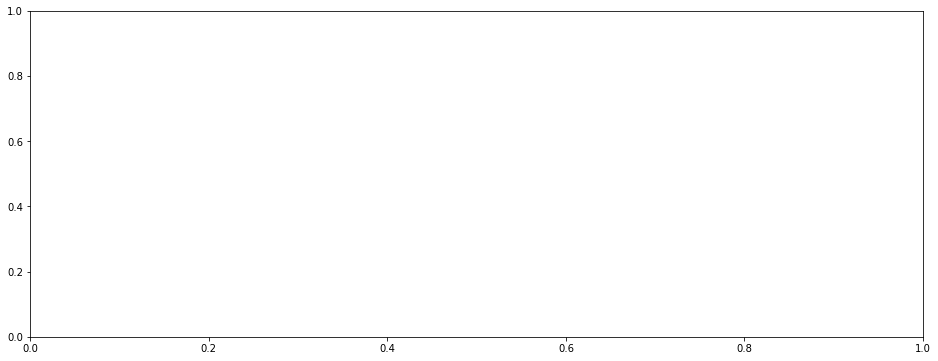

In [49]:
# plot time series of nino3.4 index for the multimodel mean dataset 
fig, axes = plt.subplots(figsize=(16,6))

func2.nino34_plot(nino34_mmm, e_date, threshold, ax = axes)

#plt.savefig('nino34_plot_mmm.png', dpi=300, bbox_inches='tight')

## next i want to classify each year as either el nino, la nino or neutral and then plot the results in a table 
to do this i need to count the number of el nino/la nina/ neutral events each year 
record count of dominant event for the year
then write the count and colour code (red el nino, blue la nina, white/grey neutral)  

# i want to do the below cell but have a count for each year 
# then i want to record the percentage of the highest event and colour code the cell that colour 

In [50]:
nino34_index = nino34_index.sel(time=slice('1883-01','1888-12'))
nino34_index

<xarray.Dataset>
Dimensions:  (model: 43, time: 72)
Coordinates:
  * time     (time) datetime64[ns] 1883-01-31 1883-02-28 ... 1888-12-31
  * model    (model) <U17 'ACCESS-CM2' 'ACCESS-ESM1-5' ... 'TaiESM1'
    month    (time) int64 dask.array<chunksize=(4,), meta=np.ndarray>
Data variables:
    ts       (model, time) float64 dask.array<chunksize=(1, 1), meta=np.ndarray>

In [51]:
# check which months are above the threshold for el nino and la nina and assign 1 for nino, -1 for nina
nino_month = xr.where(nino34_index>=threshold, 1, 0)
nina_month = xr.where(nino34_index<=-threshold, -1, 0)

nino34month = nino_month + nina_month

# Produce a table showing onset date of el nino events (anomalies above threshold that last longer than 5 months) 

In [52]:
# counts the number of el nino months in the time period and records it as a percentage 
nino_count = 100*(nino34_index.where(nino34_index>=threshold).count('time') / nino34_index.count('time'))
# counts the number of la nina months in the time period and records it as a percentage 
nina_count = 100*(nino34_index.where(nino34_index<=-threshold).count('time') / nino34_index.count('time'))
# counts the number of neutral months in the time period and records it as a percentage 
neutral_count = 100*(nino34_index.count('time')-nino_count-nina_count) / nino34_index.count('time')

In [53]:
import climtas
# find the events that exceed the el nino threshold and last longer than 5 months
nino_events0 = climtas.event.find_events(nino34_index.ts>=threshold, min_duration=5)

In [54]:
nina_events0 = climtas.event.find_events(nino34_index.ts<=-threshold, min_duration=5)

In [55]:
# extend events so that each month the event lasted is recorded and stored in the array nino_events
nino_events = climtas.event.extend_events(nino_events0)
nina_events = climtas.event.extend_events(nina_events0)

In [56]:
# get the coordinates of the events 
coords_nino = climtas.event.event_coords(nino34_index, nino_events)
coords_nina = climtas.event.event_coords(nino34_index, nina_events)

In [57]:
# Mark the type of each event (ie el nino or la nina)
coords_nino['value'] = 1
coords_nina['value'] = -1

# Join the events together
coords_all = pd.concat([coords_nino, coords_nina])

coords_all

,model,time,value
0,E3SM-1-1,1883-01-31,1
1,E3SM-1-1,1883-02-28,1
2,E3SM-1-1,1883-03-31,1
3,E3SM-1-1,1883-04-30,1
4,E3SM-1-1,1883-05-31,1
...,...,...,...
795,GISS-E2-1-G,1888-08-31,-1
796,GISS-E2-1-G,1888-09-30,-1
797,GISS-E2-1-G,1888-10-31,-1
798,GISS-E2-1-G,1888-11-30,-1


In [58]:
coords_all = coords_all.set_index('time', drop=False)

# Now group the index column into years, returning the first event in each month??
grouped_all = coords_all.groupby('model').resample('M').first()

# Drop empty years
grouped_all = grouped_all.dropna()

grouped_all[['time','model','value']]

time       model  value
model      time                                    
ACCESS-CM2 1883-01-31 1883-01-31  ACCESS-CM2    1.0
           1883-02-28 1883-02-28  ACCESS-CM2    1.0
           1883-03-31 1883-03-31  ACCESS-CM2    1.0
           1883-04-30 1883-04-30  ACCESS-CM2    1.0
           1883-05-31 1883-05-31  ACCESS-CM2    1.0
...                          ...         ...    ...
TaiESM1    1888-05-31 1888-05-31     TaiESM1    1.0
           1888-06-30 1888-06-30     TaiESM1    1.0
           1888-07-31 1888-07-31     TaiESM1    1.0
           1888-08-31 1888-08-31     TaiESM1    1.0
           1888-09-30 1888-09-30     TaiESM1    1.0

[1397 rows x 3 columns]

In [59]:
# The text for the combined result
result = grouped_all.pivot('model','time','value')
result
# Convert the types to a CSS value for each element
# See https://developer.mozilla.org/en-US/docs/Web/CSS/color_value for possible values
# type_background = {
#     1 : 'background-color: crimson',
#     -1 : 'background-color: royalblue',
#     #np.nan: 'background-color: grey',
# }
# background = result.applymap(lambda x: type_background[x])

time,1883-01-31,1883-02-28,1883-03-31,1883-04-30,1883-05-31,1883-06-30,1883-07-31,1883-08-31,1883-09-30,1883-10-31,...,1888-03-31,1888-04-30,1888-05-31,1888-06-30,1888-07-31,1888-08-31,1888-09-30,1888-10-31,1888-11-30,1888-12-31
model,,,,,,,,,,,,,,,,,,,,,
ACCESS-CM2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESS-ESM1-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AWI-CM-1-1-MR,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,NaN
AWI-ESM-1-1-LR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,...,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
BCC-CSM2-MR,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,-1.0,-1.0,-1.0,...,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
BCC-ESM1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CAMS-CSM1-0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
CAS-ESM2-0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,...,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CESM2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,1.0,1.0,NaN,NaN,-1.0,-1.0,-1.0,-1.0,-1.0


In [162]:
# Apply the CSS to the values
tab = result.style.apply(lambda x: background, axis=None)
tab

In [60]:
# convert nan values to 0 so they're a number that I can use in my colours array
result = result.replace(np.nan, 0)

In [61]:
# convert data to the right format so it can be used in my table 
ds = result.to_xarray()
#ds2 = ds.where(ds==np.nan, 0)
ds

<xarray.Dataset>
Dimensions:              (model: 42)
Coordinates:
  * model                (model) object 'ACCESS-CM2' ... 'TaiESM1'
Data variables:
    1883-01-31 00:00:00  (model) float64 1.0 0.0 0.0 0.0 ... 0.0 -1.0 1.0 0.0
    1883-02-28 00:00:00  (model) float64 1.0 0.0 1.0 0.0 ... 0.0 -1.0 1.0 0.0
    1883-03-31 00:00:00  (model) float64 1.0 0.0 1.0 0.0 ... 0.0 -1.0 1.0 0.0
    1883-04-30 00:00:00  (model) float64 1.0 0.0 1.0 0.0 ... 0.0 -1.0 1.0 0.0
    1883-05-31 00:00:00  (model) float64 1.0 0.0 1.0 0.0 ... 0.0 -1.0 1.0 0.0
    1883-06-30 00:00:00  (model) float64 1.0 0.0 1.0 0.0 ... 0.0 -1.0 0.0 0.0
    1883-07-31 00:00:00  (model) float64 1.0 0.0 1.0 0.0 ... 0.0 -1.0 0.0 0.0
    1883-08-31 00:00:00  (model) float64 0.0 0.0 1.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1883-09-30 00:00:00  (model) float64 0.0 0.0 1.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1883-10-31 00:00:00  (model) float64 0.0 0.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1883-11-30 00:00:00  (model) float64 -1.0 0.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1883-12-31 00:00:00  (model) float64 -1.0 0.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-01-31 00:00:00  (model) float64 -1.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-02-29 00:00:00  (model) float64 -1.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-03-31 00:00:00  (model) float64 -1.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-04-30 00:00:00  (model) float64 -1.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-05-31 00:00:00  (model) float64 -1.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-06-30 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-07-31 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-08-31 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-09-30 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-10-31 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 -1.0 0.0 0.0
    1884-11-30 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 0.0 0.0 1.0
    1884-12-31 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 0.0 0.0 1.0
    1885-01-31 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 0.0 0.0 1.0
    1885-02-28 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 0.0 0.0 1.0
    1885-03-31 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 0.0 0.0 1.0
    1885-04-30 00:00:00  (model) float64 0.0 -1.0 0.0 -1.0 ... 0.0 0.0 0.0 1.0
    1885-05-31 00:00:00  (model) float64 0.0 -1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1885-06-30 00:00:00  (model) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1885-07-31 00:00:00  (model) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1885-08-31 00:00:00  (model) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1885-09-30 00:00:00  (model) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1885-10-31 00:00:00  (model) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1885-11-30 00:00:00  (model) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1885-12-31 00:00:00  (model) float64 0.0 1.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1886-01-31 00:00:00  (model) float64 -1.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1886-02-28 00:00:00  (model) float64 -1.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1886-03-31 00:00:00  (model) float64 -1.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1886-04-30 00:00:00  (model) float64 -1.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    1886-05-31 00:00:00  (model) float64 -1.0 1.0 0.0 -1.0 ... 0.0 0.0 0.0 0.0
    1886-06-30 00:00:00  (model) float64 -1.0 1.0 1.0 -1.0 ... 0.0 0.0 0.0 0.0
    1886-07-31 00:00:00  (model) float64 -1.0 0.0 1.0 -1.0 ... 0.0 0.0 0.0 0.0
    1886-08-31 00:00:00  (model) float64 -1.0 0.0 1.0 -1.0 ... 0.0 0.0 0.0 0.0
    1886-09-30 00:00:00  (model) float64 -1.0 0.0 1.0 -1.0 ... 0.0 1.0 0.0 0.0
    1886-10-31 00:00:00  (model) float64 -1.0 0.0 1.0 0.0 ... 0.0 1.0 0.0 0.0
    1886-11-30 00:00:00  (model) float64 -1.0 0.0 1.0 0.0 ... 0.0 1.0 1.0 0.0
    1886-12-31 00:00:00  (model) float64 -1.0 0.0 1.0 0.0 ... 0.0 1.0 1.0 -1.0
    1887-01-31 00:00:00  (model) float64 -1.0 0.0 1.0

# i want to try and add in the models with no values here 

In [31]:
# # create an array of zeros for the models which never exceed the nino threshold of length time 
# mod_zero = np.zeros(len(ds))
# # find which models are not included in the ds xarray 
# missing_mods = nino34_index.model.where(~nino34_index.model.isin(ds.model), drop = True)

# dataset=[]
# names=[]

# for m, mods in enumerate(missing_mods):
#     dataset.append(mod_zero)
#     names.append(mods)
    
# print 
# multi_model = xr.concat(dataset, dim='model', coords = 'minimal')
# multi_model.coords['model'] = names

In [62]:
# convert data to the right format so it can be used in my table 
ds2 = ds.to_array()
ds2 = ds2.values

In [63]:
# swap the axes so the models are in the columns 
ds1 = np.swapaxes(ds2,0,1)

In [69]:
# #for r, vals in enumerate(result_type.values):
# # ds1 = result_type.values # this one also works instead of using the converted tabx array
# cell_text = []
# for i, val in enumerate(ds1):
#     row_text = []
#     for j, val2 in enumerate(val):
#         text = ds1[i,j]
#         row_text.append(text)
#     cell_text.append(row_text)
    
# cell_text

In [70]:
# set row labels
rows = ds.model.data
len(rows)

42

In [65]:
# set column labels 
cols = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']
cols = cols*6
len(cols)

72

In [66]:
# convert data to integers so I can use it to index my colour array
ds1 = ds1.astype(int)

In [67]:
# set the colours of each cell
colour_ar = np.array(['white', 'royalblue', 'crimson'])
    
    # Use the data values as indices into the colour name array
colours = colour_ar[ds1]
colours

array([['royalblue', 'royalblue', 'royalblue', ..., 'white', 'white',
        'white'],
       ['white', 'white', 'white', ..., 'white', 'white', 'white'],
       ['white', 'royalblue', 'royalblue', ..., 'royalblue', 'royalblue',
        'white'],
       ...,
       ['crimson', 'crimson', 'crimson', ..., 'royalblue', 'royalblue',
        'royalblue'],
       ['royalblue', 'royalblue', 'royalblue', ..., 'white', 'white',
        'white'],
       ['white', 'white', 'white', ..., 'white', 'white', 'white']],
      dtype='<U9')

# need to make sure all months and all models are present 

In [133]:
# trying to get the years out
# h_cols = nino34_index.groupby('time.year')#.dt.strftime("%Y").data
# h_cols = pd.DataFrame(h_cols).set_index(0, drop=True)
# h_cols

In [40]:
years = ['1883', '1884', '1885', '1886', '1887', '1888']

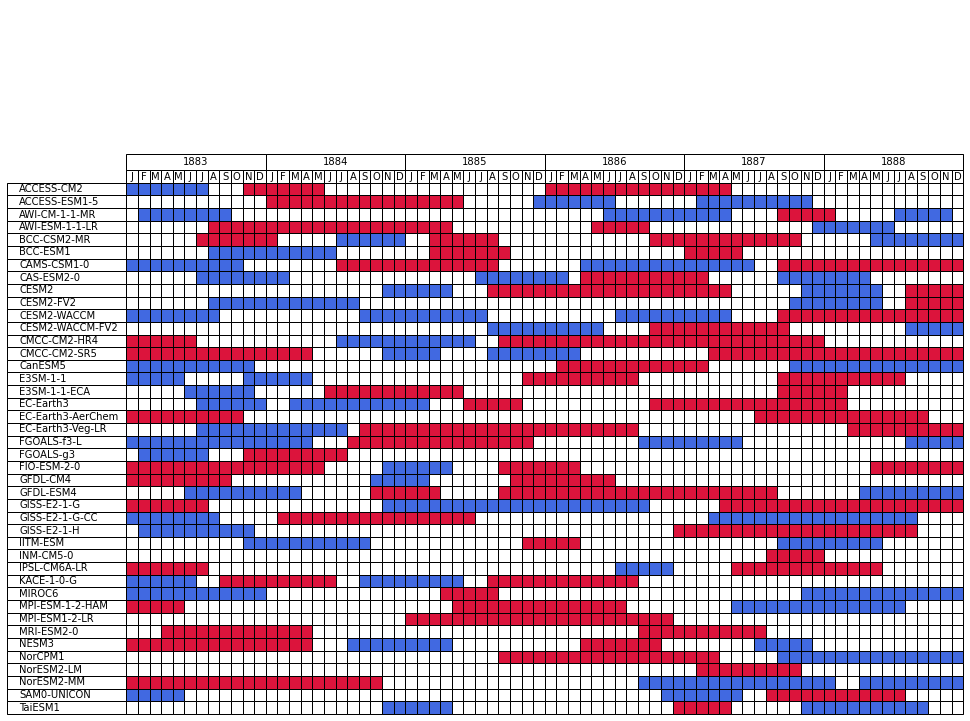

In [68]:
# Add headers and a table at the bottom of the axes
fig, ax = plt.subplots(1, figsize=(15,10))
# remove axis
ax.axis('off')

# make table
# bbox has x0, x1, y0, y1 so determines the size (and location??) of the table
header_0 = ax.table(cellText=[['']*len(years)], colLabels=years, loc='bottom', bbox=[0, 0.67, 1, 0.06])
the_table = ax.table(cellColours= colours, rowLabels=rows, colLabels=cols, loc='bottom',cellLoc='center', bbox=[0, -0.3, 1.0, 1])

plt.savefig('nino3.4_table_0.5thold.pdf', dpi=300, bbox_inches='tight')

In [75]:
func2 = reload(func2)
func = reload(func)

In [ ]:
# find the nino/nina events over the specified threshold and lasting longer than 5 months
ENSO_events_04 = func.find_ENSO(nino34_index, 0.4)

In [ ]:
# plot the results in a table 
fig, ax = plt.subplots(1, figsize=(15,10))

# call function to make the table
func2.nino34_table(ENSO_events_04)

# save table as pdf 
plt.savefig('nino3.4_table_0.4thold.pdf', dpi=300, bbox_inches='tight')

<AxesSubplot:>

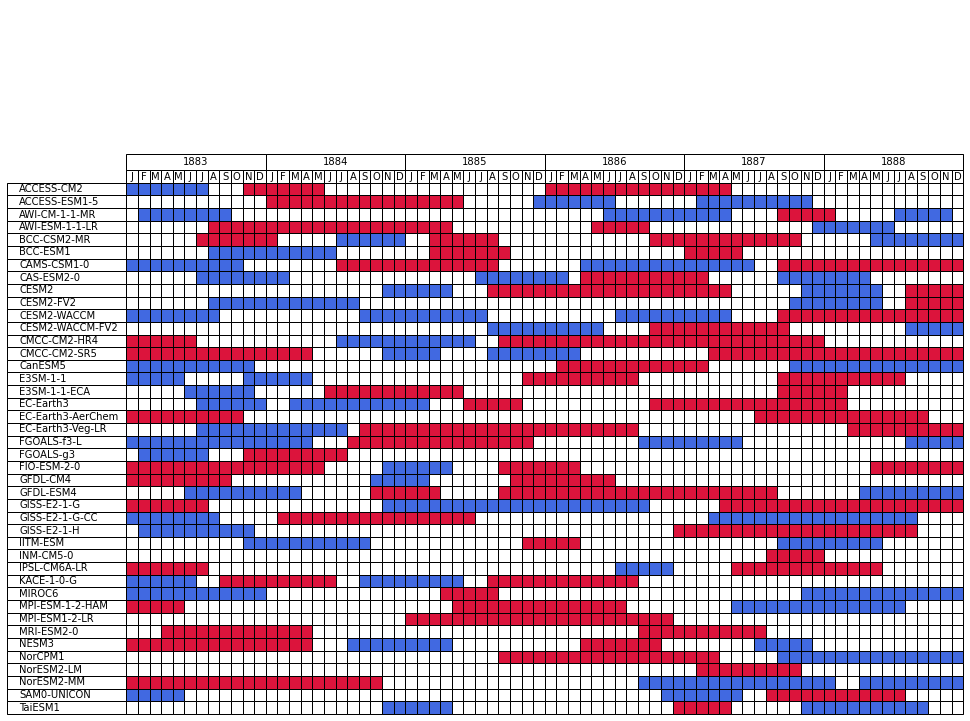

In [76]:
# plot the results in a table 
fig, ax = plt.subplots(1, figsize=(15,10))

# call function to make the table
func2.nino34_table(ENSO_events_05)

# save table as pdf 
plt.savefig('nino3.4_table_0.5thold.pdf', dpi=300, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1, figsize=(15,10))

# call function to make the table
func2.nino34_table(dataset)

# save table as pdf 
plt.savefig('nino3.4_table_0.5thold.pdf', dpi=300, bbox_inches='tight')